In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_data = '/ner_dataset.csv'
path = '/Bert_Base_Cased'

# Load Data

In [ ]:
data = pd.read_csv(path_data, encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique tags in corpus:", data['Tag'].nunique())

Unique tags in corpus: 17


In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags

17

### Task 3: Retrieve Sentences and Corresponsing Tags

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx['[PAD]'] = 0
target_vocab = len(tag2idx)

In [ ]:
target_vocab, tag2idx

(18,
 {'B-art': 1,
  'B-eve': 2,
  'B-geo': 16,
  'B-gpe': 4,
  'B-nat': 9,
  'B-org': 5,
  'B-per': 3,
  'B-tim': 14,
  'I-art': 11,
  'I-eve': 15,
  'I-geo': 10,
  'I-gpe': 17,
  'I-nat': 12,
  'I-org': 8,
  'I-per': 6,
  'I-tim': 7,
  'O': 13,
  '[PAD]': 0})

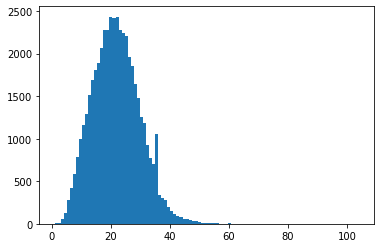

In [ ]:
plt.hist([len(s) for s in sentences], bins=100) # Length of sentences
plt.show()

In [ ]:
training_sentences = [[w[0] for w in s] for s in sentences]
training_labels = [[w[2] for w in s] for s in sentences]
num_samples = len(training_sentences[:10000])
num_samples

10000

In [ ]:
training_sentences = training_sentences[:num_samples]
training_labels = training_labels[:num_samples]

In [ ]:
from transformers import BertTokenizer, TFBertForTokenClassification

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=path)


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
      tokenized_sentence = ['[CLS]']
      labels = ['O']
      for word, label in zip(sentence, text_labels):
    # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
    # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
    # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)
      tokenized_sentence.append('[SEP]')
      labels.append('O')
      return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(training_sentences, training_labels)]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN =64
X = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
y = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["[PAD]"], padding="post",
                     dtype="long", truncating="post")
attention_masks = [[int(i != 0.0) for i in j] for j in X]

In [ ]:
indxtotag = {t: i for i, t in tag2idx.items()}

# Load Model

In [ ]:
BUFFER_SIZE = len(X)
BATCH_SIZE = 64

data = tf.data.Dataset.from_tensor_slices((X, attention_masks, y)).shuffle(BUFFER_SIZE)
data = data.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
for x,y,z in data:
    print(x.shape, y.shape, z.shape)
    break

(64, 64) (64, 64) (64, 64)


In [ ]:
SIZE = num_samples/BATCH_SIZE
SPLIT = 0.9
SIZE*SPLIT*BATCH_SIZE

9000.0

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
  
data = data.map(map_func)

train = data.take(int(SIZE*SPLIT))
val = data.skip(int(SIZE*SPLIT))

del data

In [ ]:
model = TFBertForTokenClassification.from_pretrained(
"bert-base-cased",
num_labels=len(tag2idx),
output_attentions = False,
output_hidden_states = False
)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    logits = model(inp['input_ids'], token_type_ids=None, attention_mask=inp['attention_mask']).logits
    loss = loss_object(tar, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, logits)
  return loss
def val_step(inp, tar):
  logits = model(inp['input_ids'], token_type_ids=None, attention_mask=inp['attention_mask']).logits
  loss = loss_object(tar, logits)
  test_accuracy.update_state(tar, logits)
  return loss  

In [ ]:
import time
EPOCHS = 8
history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[],
  "val_loss" :[],
  "val_Accuracy" :[]
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  val_loss = 0
  # TRAIN LOOP
  for (batch, (inp, tar)) in enumerate(train):
      batch_loss = train_step(inp,tar)
      total_loss = total_loss + batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  history['Accuracy'].append(train_accuracy.result())  
  for (batc, (inp, tar)) in enumerate(val):
      batch_loss = val_step(inp,tar)
      val_loss += batch_loss
  history['val_loss'].append(val_loss/(batc+1))
  history['val_Accuracy'].append(test_accuracy.result())  
  if (epoch+1) % 1 == 0: 
        print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}, Val_Loss: {val_loss/(batc+1):.4f}, Val Accuracy: {test_accuracy.result():.4f}') 
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.5362, Accuracy: 0.8937, Val_Loss: 0.1447, Val Accuracy: 0.9602
Time taken for 1 epoch: 68.80 secs

Epoch 2, Loss: 0.1048, Accuracy: 0.9718, Val_Loss: 0.0773, Val Accuracy: 0.9796
Time taken for 1 epoch: 61.13 secs

Epoch 3, Loss: 0.0712, Accuracy: 0.9806, Val_Loss: 0.0583, Val Accuracy: 0.9847
Time taken for 1 epoch: 61.12 secs

Epoch 4, Loss: 0.0573, Accuracy: 0.9842, Val_Loss: 0.0499, Val Accuracy: 0.9866
Time taken for 1 epoch: 61.11 secs

Epoch 5, Loss: 0.0473, Accuracy: 0.9869, Val_Loss: 0.0368, Val Accuracy: 0.9903
Time taken for 1 epoch: 61.13 secs

Epoch 6, Loss: 0.0385, Accuracy: 0.9895, Val_Loss: 0.0291, Val Accuracy: 0.9925
Time taken for 1 epoch: 61.12 secs

Epoch 7, Loss: 0.0307, Accuracy: 0.9916, Val_Loss: 0.0242, Val Accuracy: 0.9937
Time taken for 1 epoch: 61.14 secs

Epoch 8, Loss: 0.0250, Accuracy: 0.9932, Val_Loss: 0.0188, Val Accuracy: 0.9950
Time taken for 1 epoch: 61.11 secs



In [ ]:
def evaluate(inp):
    logits = model(inp['input_ids'], token_type_ids=None, attention_mask=inp['attention_mask']).logits
    predicted_id = tf.argmax(logits, axis=-1)
    return logits, predicted_id

In [ ]:
start = time.time()
for (batch, (inp, tar)) in enumerate(val):
    x_test = inp
    y_test = tar
    logits,prob = evaluate(inp)
    test_accuracy.update_state(tar, logits)
print('Accuracy of model on Test : ', test_accuracy.result().numpy())
print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Accuracy of model on Test :  0.9948017
Time taken for 1 epoch: 2.49 secs



In [ ]:
i = np.random.randint(0, x_test['input_ids'].shape[0]) #659
p = prob[i]
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
test = tokenizer.convert_ids_to_tokens(x_test['input_ids'][i])
for w, true, pred in zip(test, y_true, p):
    print("{:15}{}\t{}".format(w, indxtotag[true.numpy()], indxtotag[pred.numpy()]))
    if w == '[SEP]':
      break

Word           True 	 Pred

------------------------------
[CLS]          O	O
Em             O	O
##bed          O	O
##ded          O	O
reporters      O	O
in             O	O
Fall           B-geo	B-geo
##u            B-geo	B-geo
##jah          B-geo	B-geo
say            O	O
troops         O	O
searching      O	O
the            O	O
safe           O	O
house          O	O
property       O	O
found          O	O
photographs    O	O
,              O	O
notes          O	O
,              O	O
ammunition     O	O
and            O	O
letters        O	O
thought        O	O
to             O	O
be             O	O
from           O	O
al             B-per	B-per
-              B-per	B-per
Z              B-per	B-per
##ar           B-per	B-per
##qa           B-per	B-per
##wi           B-per	B-per
.              O	O
[SEP]          O	O
